**030-binomial**

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as st
import arviz as az

# Inferring a Binomial Probability via Exact Analysis (Chapter 6)

* Goal: We have a series of Boolean experiments (independent coin tosses). We want to analyze how the prior belief about bias should be updated after observing this series.

* Method: Pen and pencil analysis

* We have two nominal outcomes $y\in \{0,1\}$. A Nominal Number is a number used only as a name, or to identify something (not as an actual value or position)


* Nominal means that they are unordered.  The numeric values 0 and 1 have no meaning, we could flip them. We chose them just for convenience.

## Likelihood

* We start with seeking the likelihood function.  Recall that for a given coin the outcome $y$ is described by a Bernoulli distribution with parameter $\theta$:

$$
p (y \mid \theta) = \theta^y (1-\theta)^{(1-y)}
$$

* Note that $p (y=1 \mid \theta) = \theta^1\theta^0 = \theta$; just a reminder that $\theta$ is basically the probability of success.

* The above function is a **probability distribution** given a concrete $\theta$ value.

* However, when we do an observation of (learning from) an experiment result we know the value of $y$, not the value of $\theta$.

* The reinterpretation of a probability function in which the outcome is known, but the parameters are free is called **likelihood**.

* Note that likelihood **is not a probability**, as it does not satisfy Kolmogorov's axioms.  In particular, for $y=1$,

$$
\int_o^1 \theta^y(1-\theta)^{(1-y)} d\theta = \int_0^1 \theta d\theta = \frac{1}{2}
$$

* Recall, that likelihood is not a function that gives a probability of an outcome, but a function that tells us (on the scale from 0 to 1) how well a given valuation of model parameters explain the outcome.

* Last week we agreed that if we know a result of $N$ experiments then the likelihood is

$$
p (\{y_i\}_{i=1}^N \mid \theta) = \theta^{\#\textrm{heads}} (1-\theta)^{\#\textrm{tails}}
$$

* This chapter changes the notation slightly. We assume $N$ experiments and $z$ successes, so $\#\textrm{heads}=z$ and $\#\textrm{tails}=N-z$. 

* Then

$$
p (\{y_i\}_{i=1}^{N} \mid \theta) = \theta^{z} (1-\theta)^{N-z}
$$

* Recall that Bayes theorem says (specialized for the experiment of $N$ coin tosses as above):

$$
p (\theta \mid \{y_i\}_{i=1}^{N}) = \frac{p (\{y_i\}_{i=1}^{N} \mid \theta) \cdot p(\theta)}{p(\{y_i\}_{i=1}^{N})}
$$

* So the above definition of likelihood is something we will need to plug in the bayes rule above in order to compute the posterior probability distribution over $\theta$, which captures what we have learnt about $\theta$ after executing the experiment.

## Prior

* What should be the prior? It would be nice to have a prior function $p(\theta)$ such that when multipled by the likelihood. $p(y \mid \theta)p(\theta)$ we get a function of the same form. 
* This way after learning from $N$ experiments, we obtain a posterior that looks the same as the prior, so if we run more experiments, we can use the same analytical procedure to continue learning / inference.
* A prior which, when multiplied by the likelihood, gives a function of the same form is called a **conjugate prior** wrt (with respect to) this likelihood function.
* Since we are working analytically, we also need to be able to compute the denominator in the Bayes theorem, $p(\{y_i\}_{i=1}^{N}) = \int_0^1 p (\{ y_i\} \mid \theta) p (\theta)d\theta$, analytically. Computing integrals is not always easy or possible, so we need a form that would allow solving this. 
* Our likelihood is of the form $\theta^a(1-\theta)^b$, so if we multiply it by some function of the same form $\theta^k(1-\theta)^l$ we will still obtain a thing of the same format: $\theta^{a+k}(1-\theta)^{b+l}$.
* A probability density function (Q. why do we need a density for the prior here?) is called Beta:
$$
p(\theta \mid a,b) = \textrm{beta} (\theta | a,b) = \frac{\theta^{a-1}(1-\theta)^{b-1}}{B(a,b)} = \frac{\theta^{a-1}(1-\theta)^{b-1}}{ \int_0^1 \theta^{a-1}(1-\theta)^{b-1}d\theta }
$$
* where the denominator is the normalizing function also called the beta function $\textrm{B}(a,b)$ (the entire distribution is called a beta distribution, and the denominator is called the beta function)
* The beta distribution is only defined for $\theta\in[0,1]$ and for postiive values of $a$ and $b$ (which suits our case well)
* Below we explore the Beta distribution in practice, to give you an idea how to pick the parameter for your prior.

* In PyMC3 Beta distribution is in [pymc3.distributions.continuous.Beta](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Beta)
* Below we reconstruct Fig. 6.1 by instantiating the above beta function and using it for plotting.
* In PyMC3, any distribution has a function logp that returns logarithm of probability values of random variables at given point.  
* We instantiate the beta distribution for all combinations of parameters $\alpha$ and $\beta$, like in the book, compute logp values in 100 points, take natural exponential of these values, and plot.
* Beware, the computation may take a bit of time (feels like a minute or so)

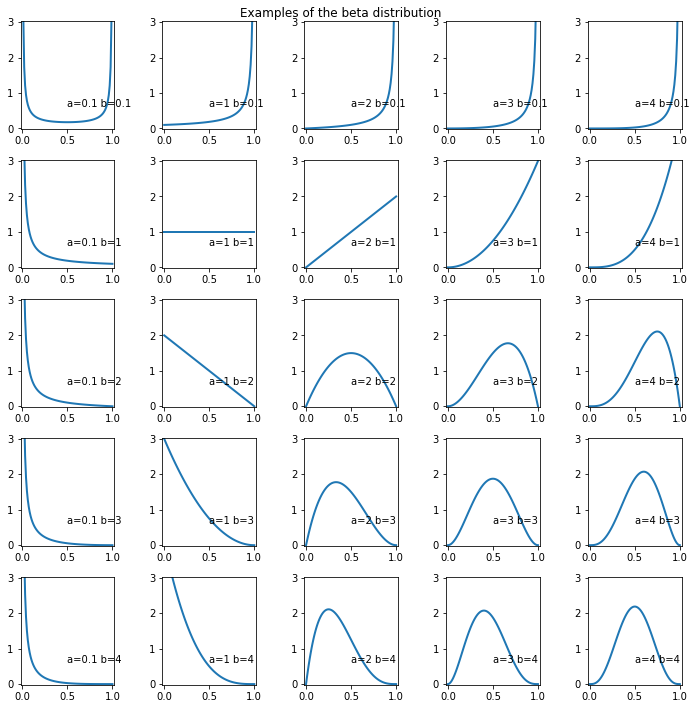

In [2]:
fig, ax = plt.subplots(5,5, figsize=(10,10))
fig.suptitle('Examples of the beta distribution')
fig.tight_layout()
fig.subplots_adjust(top=0.96)

params = [0.1, 1, 2, 3, 4]
domain = np.linspace(0.0, 1.0, 100)
for i in range(0, 5):
    for j in range(0, 5):
        with pm.Model():
            beta = pm.Beta(
                name=f"theta", 
                alpha=params[j], 
                beta=params[i], 
                transform=None
            )
            image = [ math.exp( beta.logp( {"theta": theta} ) ) # scipy also implements density functions, might be easier and faster to use directly
                         for theta in domain
                    ]
            ax[i][j].plot(domain, image, linewidth=2)
            ax[i][j].text(0.5, 0.6, f"a={params[j]} b={params[i]}")
            ax[i][j].axis([-0.02, 1.02, -0.02, 3.02])
plt.show()

* The first aprameter, $\alpha$ grows from left to right.
* As expected, as $\alpha$ grows, we see the mode of $\theta$ shifting towards the right (so  high probability of success is more likely and likely)
* The second parameter, $\beta$ grows from top to bottom
* As we need, this means that the probability of likely success is decreasing (the coin would be tail biased)
* This is because we want growing $\alpha$ and $\beta$ parameters to reflect the observed number of heads and tails.
* With this in mind inspect the diagonal of the plot above: 
    * when we are seeing the same value of $\alpha$ and $\beta$ we expect that the mode of the distribution is 0.5 since the coin is most likely unbiased. 
    * Higher the values of the parameters, the density should concentrate around 0.5 as we are increasingly convinced that the coin is unbiased.
    * This makes sense for values from 2 and above
    * Value 1 merely means that we know that the coin has two sides, but we have not run any experiments yet.

## Specifying a prior using Beta distribution

### Prior knowledge about success/failure rates
* The above suggests that if you have seen approximately $a$ heads and $b$ tails in the past with your object of experimentation (the coin) then you should set the prior parameters to $a$ and $b$.
* What if you have not done any experiments? For instance, you expect that your teacher is in good mood in 90% of lectures.  Should we set a=9 and b=1 or a=90 and b=10?
* One strategy is to ask yourself: how many cases you would have to see to be convinced otherwise about your teacher? 
    * If you need to see 10 more weeks of contrary data to change your mind about your teacher being nice, then set a=9 and b=1 so a+b=10
    * If you are so convinced that you need to see 100 more weeks of contrary data to change your mind then set a=90 and b=10, and so on.
* This allows to adjust for phenomena that happen in large and small quantities (say lectures, vs people developing a rare disease for which we have a lot of prior data)

### Prior knowledge about mean / mode and concentration
* Sometimes it is easier to specify the prior in terms of mean (your expectation about the coin bias) and concentration (how sure you are about the mode).
* The mean of $\beta(\theta \mid a,b)$ is $\mu = \frac{a}{a+b}$
* The mode of $\beta(\theta \mid a,b)$ is $\omega = \frac{a-1}{a+b-2}$ for $a, b \gt 1$
* As expected from the above discussion, when $a = b$ we have $\mu = \omega = 0.5$
* For convenience we introduce $\kappa$, a concentration parameter: $\kappa = a + b$.  This is quite intuitive; we observed above that once $a+b$ grows, we are more convinced about the mode, so the density should increasingly concentrate about one point. Then

$$
\mu = \frac{a}{\kappa} \quad \text{and} \quad \omega = \frac{a-1}{\kappa-2} \enspace \text{for } a \gt 1, \enspace \kappa \gt 2
$$

* Now we can rewrite $a$ and $b$ in terms of the mean and concentration:

$$
a = \mu\kappa \quad \text{and} \quad b = \kappa - a = \frac{a}{\mu} - a = \frac{a - \mu a}{\mu} = \frac{a}{\mu}(1-\mu) = (1-\mu)\kappa
$$

* Or (similarly) in terms of mode and concentration:

$$
a= \omega (\kappa -2)+1 \quad \text{and} \quad b = (1-\omega)(\kappa-2)+1 \quad \text{for } \kappa\gt2
$$

* When should we use mean and when should we use mode? For symmetric distributions there is no difference. Mode and mean are the same.  For asymetric distributions, mode is more intuitive.  Mean is shifted towards the longer tail of the distribution. We reproduce Fig. 6.2 from the text book below, to allow you appreciating it:

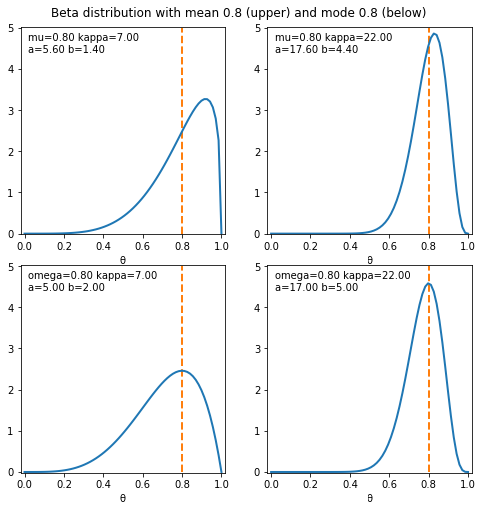

In [3]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.suptitle('Beta distribution with mean 0.8 (upper) and mode 0.8 (below)')
fig.tight_layout()
fig.subplots_adjust(top=0.94)

param_kappa = [7, 22]
domain = np.linspace(0.0, 1.0, 70)
mu = 0.8
omega = 0.8

def a_from_mu (mu, kappa): return mu*kappa
def b_from_mu (mu, kappa): return (1-mu)*kappa
def a_from_omega (omega, kappa): return omega*(kappa-2)+1
def b_from_omega (omega, kappa): return (1-omega)*(kappa-2)+1

def plot_beta (ax, a, b, mu, kappa, label):
    with pm.Model():
        beta = pm.Beta(
            name=f"theta", 
            alpha=a,
            beta=b,
            transform=None
        )
        image = [ math.exp( beta.logp( {"theta": theta} ) ) 
                    for theta in domain
        ]
        ax.vlines([mu], ymin=0, ymax=5.0, color='C1', ls='--', linewidth=2)
        ax.plot(domain, image, linewidth=2)
        ax.text(0.02, 4.7, f"{label}={mu:0.2f} kappa={kappa:0.2f}") # I change 0d to 0.2f
        ax.text(0.02, 4.4, f"a={a:0.2f} b={b:0.2f}")
        ax.axis([-0.02, 1.02, -0.02, 5.02])
        ax.axis([-0.02, 1.02, -0.02, 5.02])
        ax.set_xlabel('θ')       
        
for i in range(0, 2):
    a = a_from_mu (mu, param_kappa[i])
    b = b_from_mu (mu, param_kappa[i])
    plot_beta(ax[0,i], a, b, mu, param_kappa[i], "mu")
    
for i in range(0, 2):
    a = a_from_omega (omega, param_kappa[i])
    b = b_from_omega (omega, param_kappa[i])
    plot_beta(ax[1,i], a, b, omega, param_kappa[i], "omega")
    
plt.show()

* In the left column, $\kappa$ is smaller, thus the distribution is wider.
* In the right column, the concentration $\kappa$ is larger, thus the distribution is more narrow.
* In the top row, we show densities with mean $\mu=0.8$ it is a bit hard to guess the shape.
* In the bottom row, we show densities with mode $\omega=0.8$. Here we know that the peak of the density is at the mode point.

### Prior knowledge about mean and standard deviation

* PyMC3 allows to parameterize the distribution using a,b ($\alpha$, $\beta$) as we did above, and using mean and standard deviation ($\sigma$).  No worries though. [The documentation](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Beta) shows how to compute variance (the square of standard deviation) from values of a, b, and how to get $\kappa$ form variance and mean. These are also listed in equation (6.7) in the book.
* Beware than when using standard deviation the value should be less 0.28867 (this is a standard deviation of a uniform distribution on [0,1] which is the most uninformed distribution on $\theta$).

## Posterior Analysis with a Beta Prior (Section 6.3)

* We have a prior candidate, and a likelihood, we can compute the posterior density using Bayes rule:

\begin{align}
    p(\theta \mid z, N) & = \frac{p (z, N \mid \theta) p(\theta)}{p(z,N)} \\[5mm]
                        & = \theta^z (1-\theta)^{N-z} \frac{\theta^{a-1}(1-\theta)^{b-1}}{B(a,b)p(z,N)}\\[5mm]
                        & = \frac{\theta^{(z+a)-1} (1-\theta)^{(N-z+b)-1}}{B(a,b)p(z,N)}\\[5mm]
                        & = \frac{\theta^{(z+a)-1} (1-\theta)^{(N-z+b)-1}}{B(z+a,N-z+b)}\\[5mm]
                        & = \textrm{beta}(z+a,N-z+b)
\end{align}

* The last step above is non-obvious; We have looked at the numerator, and noticed that it looks like a numerator of a beta density function with $\alpha=z+a$ and $\beta=N-z+b$.
* By definition beta function $\textrm{B}(z+a,N-z+b)$ is thus a normalizing denominator for this numerator. (Check the section about the beta density function above.)
* As we wanted we obtained a posterior in the same form as the prior (a beta density function)
* **Computing a posterior for $N$ Bernoulli experiments with a beta prior amounts to computing a new beta density with updated parameters**

## Posterior as a compromise of prior and likelihood
* We were discussing this last week, using grid approximation graphs
* We try to appreciate this analytically this week.
* Recall that beta distributions have mean determined using parameters.
* It turns out that the posterior mean can be expressed as a weighted average of the likelihood average and prior mean:

<img src="posterior-mean.png">

* The left-hand side above is the mean of the posterior (Why?)
* The second component "data" is the proportion of heads in the data
* The third component "prior" is the beta distribution mean for the prior
* The likelihood is weighed by the fraction of experimetns in the total amount of knowledge (number of trials we have seen, or believe we have seen)
* The prior is weighed by the fraction of prior belief in the total amount of experience (number of trials we have seen, or believe we have seen)
* In both weights the denominator is the total number of trials and knowledge we have
* So the extent of the shift of the mean will depend on the proportion between the prior parameters a,b and the number of experiments in the data.

<img src="prior-compromise.png" width="500">
Copyright © Kruschke, J. K. (2014). Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan. 2nd
Edition. Academic Press / Elsevier.

## Priors that are not a beta distribution

* If we cannot express the prior as a beta distribution, another posterior calculation method is needed.
    * For example if our prior is not unimodal.(In mathematics, unimodality means possessing a unique mode. More generally, unimodality means there is only a single highest value, somehow defined, of some mathematical object.) 
    For instance we know results come from two wildly different populations but we do not know from which one.
* We can use *grid approximation* like last week.
    * This relied on selecting discrete values of $\theta$ and prior values for them  (for a finite number we can always choose constants we believe in for any shape)
    * The likelihood equation is the same both week and this week.
    * We can obtain a grid approximating the posterior by sampling the Bayes rule for different values of theta

Unimodal distribution: Oftentimes distributions will have a clear peak to their shape. They will peak in just one place on the distribution

Bimodal distribution: You might have a distribution that will have two distinct regions with lots of data points, and a gap in the middle. When this happens, the two peaks form on the distribution. And those are both called modes.

Multimodal distribution: A distribution where there are many values or bins that contain more data than other nearby bins, usually separated by gaps.

# Homework Exercises

1. Study Section 6.4.2 and reproduce Fig. 6.5 in Python.  Follow the same method we used in week 2 using 1000 intervals for $\theta$
2. Exercise 6.1 (make sure that you plot the intermediate posteriors, and compare the plots; you can reuse the plotting code from above, or make your own; or use any other way of plotting the beta density function given parameters, an online service, etc.)
3. Exercise 6.2 (you can plot HDP instead of HDI using pymc3.stats.hpd, or using posterior plots with credible_interval argument as we used in the last two weeks)
4. Exercise 6.3
5. Exercise 6.4 + 6.5

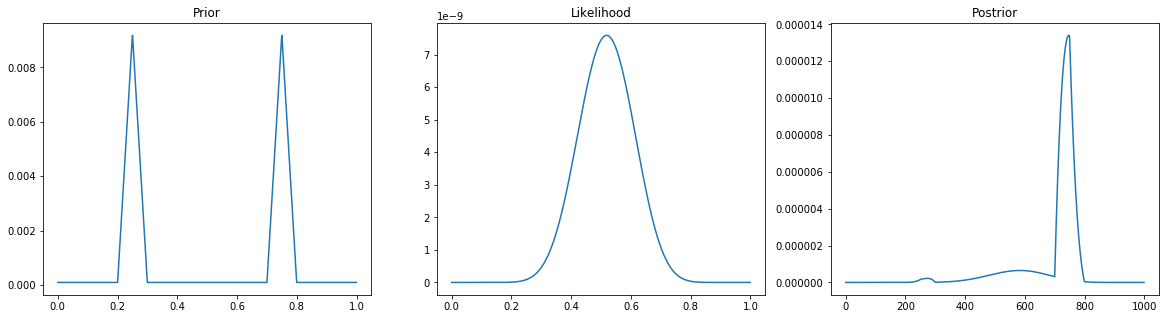

In [4]:
# 1) Study Section 6.4.2 and reproduce Fig. 6.5 in Python. Follow the same method we used in week 2 using 
# 1000 intervals for 𝜃

# pTheta = np.concatenate ( (np.zeros(200), np.linspace (0, 100, 50), 
#                            np.linspace (100,0, 50), np.zeros (400), 
#                            np.linspace (0, 100, 50), np.linspace (100,0, 50), 
#                            np.zeros (200) ))

# pTheta = np.concatenate ( (np.ones(200), np.linspace (1, 100, 50), 
#                            np.linspace (100,1, 50), np.ones (400), 
#                            np.linspace (1, 100, 50), np.linspace (100,1, 50), 
#                            np.ones (200) ))
domain = np.arange (0.0,1.0000,0.001)

pTheta = np.concatenate ( (np.ones(200), np.arange (1, 101, 2), 
                           np.arange (100,0, -2), np.ones (400), 
                           np.arange (1, 101, 2), np.arange (100,0, -2), 
                           np.ones (200) ))


pTheta = pTheta/sum(pTheta)  # Make pTheta sum to 1.0. Normalize



def likelihood(z, N, θ):
    return (θ**z) * ((1-θ)**(N-z)) 

# Equation 5.8   
def normalization_const_n (z, N): 
    return np.sum(np.multiply (likelihood (z,N,domain), domain))

# Equation 5.7
def posterior_n (z,N):
    denominator = normalization_const_n (z, N)
    numerator = np.multiply(likelihood (z, N, domain), pTheta)
    return numerator / denominator 

# def logp(failure, value):
#     return (failure * log(λ) - λ * value).sum()

# exp_surv = pm.DensityDist('exp_surv', logp, observed={'failure':failure, 'value':t})

def logp(failure, value):
    return (failure * log(λ) - λ * value).sum()

fig, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].set_title("Prior")
ax[0].plot(domain, pTheta)

ax[1].set_title("Likelihood")
ax[1].plot(domain, likelihood(14,27,domain))

ax[2].set_title("Postrior")
ax[2].plot(posterior_n(14,24))

plt.show()




**Exercise 6.1**

Exercise 6.1. [Purpose: For you to see the influence of the prior in each
successive flip, and for you to see another demonstration that the posterior is invariant under re-orderings of the data.] For this exercise, use the R function
explained in Section 6.6 ( BernBeta.R ). (Don’t forget to source the function before
calling it.) Notice that the function returns the posterior beta values each time it is
called, so you can use the returned values as the prior values for the next function call.

(A) Start with a prior distribution that expresses some uncertainty that a coin is
fair: beta(θ|4, 4). Flip the coin once; suppose we get a head. What is the posterior
distribution?

(B) Use the posterior from the previous flip as the prior for the next flip. Suppose
we flip again and get a head. Now what is the new posterior? (Hint: If you type
post = BernBeta( c(4,4) , c(1) ) for the first part, then you can type post =
BernBeta( post , c(1) ) for the next part.)

(C) Using that posterior as the prior for the next flip, flip a third time and get a tail.
Now what is the new posterior? (Hint: Type post = BernBeta( post , c(0) ) .)

(D) Do the same three updates but in the order T, H, H instead of H, H, T. Is the
final posterior distribution the same for both orderings of the flip results?

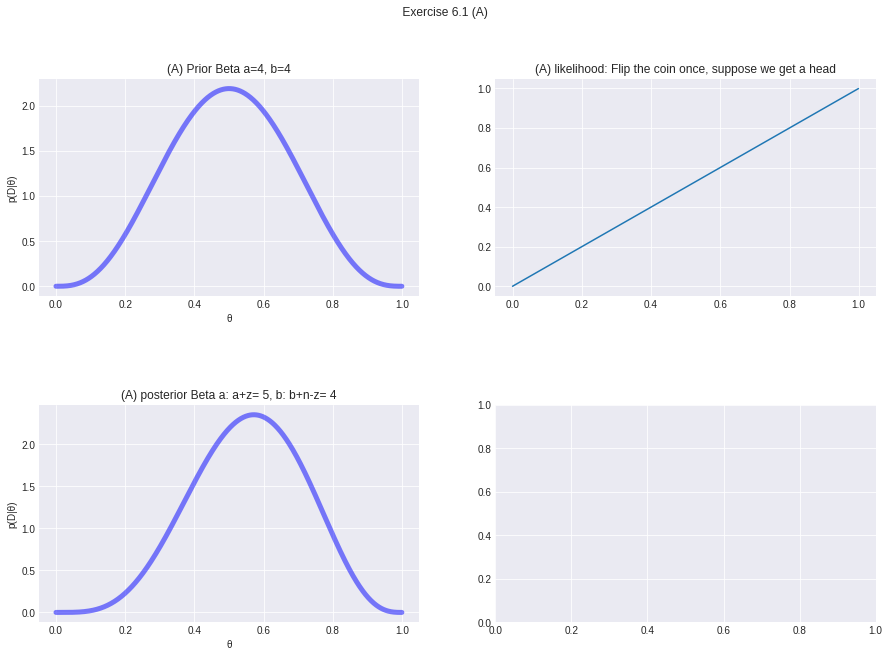

In [5]:
# Exercise 6.1. [Purpose: For you to see the influence of the prior in each successive flip, and for you to see 
# another demonstration that the posterior is invariant under re-orderings of the data.] For this exercise, 
# use the R function explained in Section 6.6 ( BernBeta.R ). (Don’t forget to source the function before 
# calling it.) Notice that the function returns the posterior beta values each time it is called, so you can
# use the returned values as the prior values for the next function call.

plt.style.use('seaborn-darkgrid')
import scipy.stats as st
fig, ax = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle(' Exercise 6.1 (A)')
fig.subplots_adjust(hspace = 0.5) # add some vertical whitespace so that plots do not overlap

# 6.1 A) Start with a prior distribution that expresses some uncertainty that a coin is fair: beta(θ|4, 4). 
# Flip the coin once; suppose we get a head. What is the posterior distribution?

a, b = 4, 4

Theta = np.arange(0.000, 1, 0.001)
# pTheta = dbeta( Theta , a , b ) # prior for plotting
# mean, var, skew, kurt = st.beta.stats(a, b, moments='mvsk')
pTheta = st.beta.stats(a, b, moments='mvsk')
# pDataGivenTheta = Theta**z * (1-Theta)**(N-z) # likelihood for plotting
# pThetaGivenData = st.beta.stats(a+z , b+N-z ) # posterior for plotting
def Likelihood(θ, n, z): return θ**z * (1-θ)**(n-z) # Bernouli/binomial likelihood

# Prior
x = np.arange(0.00, 1.01, 0.01)      
ax[0,0].set_title('(A) Prior Beta a=4, b=4') 
ax[0,0].plot(Theta, st.beta.pdf(Theta, a, b),'b-', lw=5, alpha=0.5, label='beta pdf')
ax[0][0].set_xlabel('θ')
ax[0,0].set_ylabel('p(D|θ)')

# likelihood
ax[0,1].set_title('(A) likelihood: Flip the coin once, suppose we get a head') 
ax[0,1].plot(Theta, Likelihood(Theta, 1, 1))

n = 1 #we flip coin once 
z = 1 #get a head 
# posterior
ax[1,0].set_title('(A) posterior Beta a: a+z= 5, b: b+n-z= 4') 
ax[1,0].plot(Theta, st.beta.pdf(Theta, a+z, b+n-z),'b-', lw=5, alpha=0.5, label='beta pdf')
ax[1][0].set_xlabel('θ')
ax[1,0].set_ylabel('p(D|θ)');


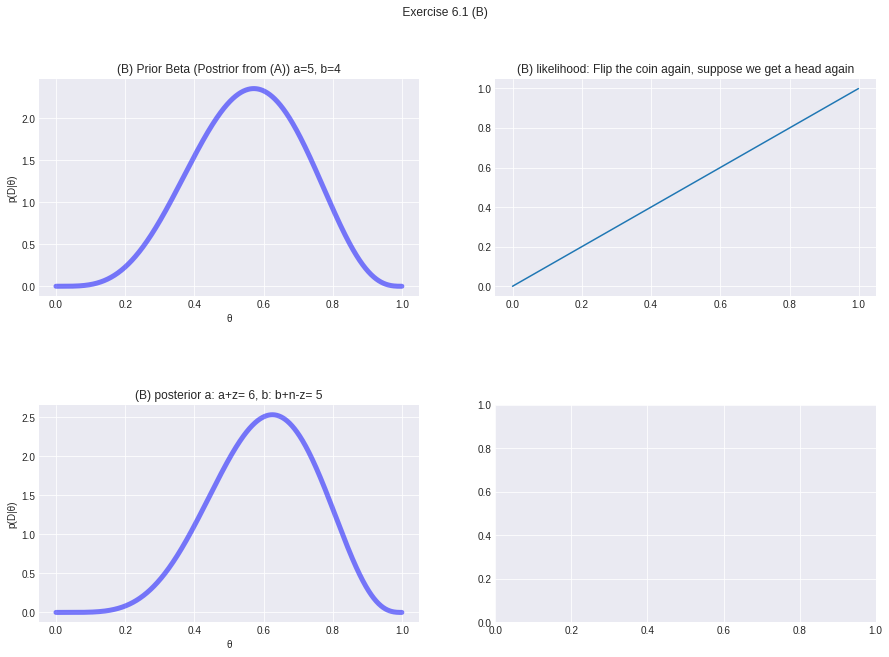

In [6]:
# 6.1 B) Use the posterior from the previous flip as the prior for the next flip. 
# Suppose we flip again and get a head. Now what is the new posterior? 

fig, ax = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle(' Exercise 6.1 (B)')
fig.subplots_adjust(hspace = 0.5) 

Theta = np.arange(0.000, 1, 0.001)
a , b = 5, 4
# Prior
# x = np.arange(0.00, 1.01, 0.01)      
ax[0,0].set_title('(B) Prior Beta (Postrior from (A)) a=5, b=4') 
ax[0,0].plot(Theta, st.beta.pdf(Theta, a, b),'b-', lw=5, alpha=0.5, label='beta pdf')
ax[0][0].set_xlabel('θ')
ax[0,0].set_ylabel('p(D|θ)')


# likelihood
ax[0,1].set_title('(B) likelihood: Flip the coin again, suppose we get a head again') 
ax[0,1].plot(Theta, Likelihood(Theta, 1, 1)) 

#TODO Should I update n and z? NO. Since you calculate it before in last probabillity.
# n, z = 1, 1
n = 1 #we flip again 
z = 1 #get a head again
ax[1,0].set_title('(B) posterior a: a+z= 6, b: b+n-z= 5') 
ax[1,0].plot(Theta, st.beta.pdf(Theta, a+z, b+n-z),'b-', lw=5, alpha=0.5, label='beta pdf')
ax[1,0].set_xlabel('θ')
ax[1,0].set_ylabel('p(D|θ)');

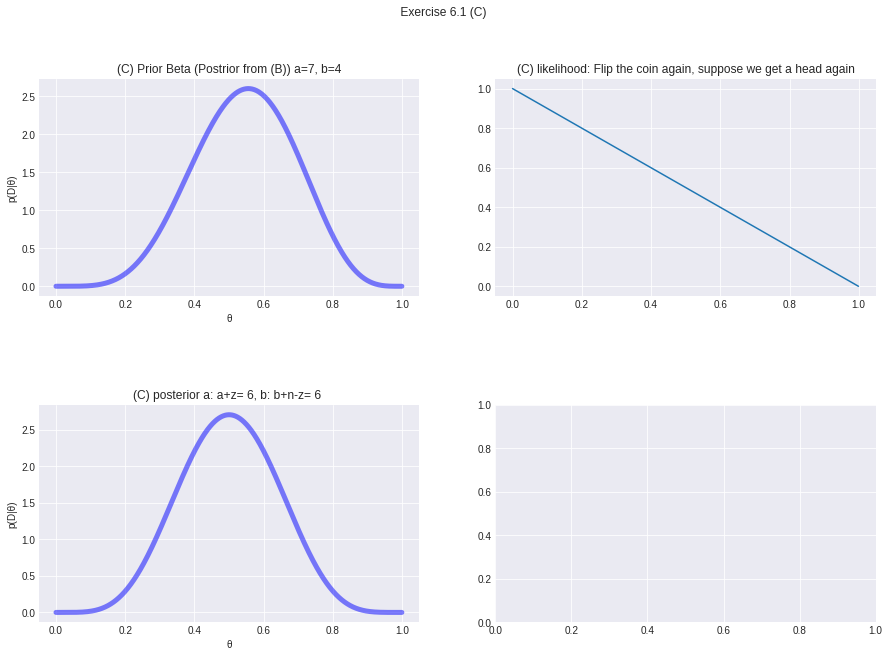

In [7]:
# C) Using that posterior as the prior for the next flip, flip a third time and get a tail. 
# Now what is the new posterior? 
# (Hint: Type post = BernBeta( post , c(0) ) .)

fig, ax = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle(' Exercise 6.1 (C) ')
fig.subplots_adjust(hspace = 0.5) 

Theta = np.arange(0.000, 1, 0.001)
a , b = 6, 5

# Prior
# x = np.arange(0.00, 1.01, 0.01)      
ax[0,0].set_title('(C) Prior Beta (Postrior from (B)) a=7, b=4') 
ax[0,0].plot(Theta, st.beta.pdf(Theta, a, b),'b-', lw=5, alpha=0.5, label='beta pdf')
ax[0][0].set_xlabel('θ')
ax[0,0].set_ylabel('p(D|θ)')


# likelihood
ax[0,1].set_title('(C) likelihood: Flip the coin again, suppose we get a head again') 
ax[0,1].plot(Theta, Likelihood(Theta, 1, 0)) 

n = 1 #we flip again 
z = 0 #get a tail
ax[1,0].set_title('(C) posterior a: a+z= 6, b: b+n-z= 6 ') 
ax[1,0].plot(Theta, st.beta.pdf(Theta, a+z, b+n-z),'b-', lw=5, alpha=0.5, label='beta pdf')
ax[1,0].set_xlabel('θ')
ax[1,0].set_ylabel('p(D|θ)');

D) Do the same three updates but in the order T, H, H instead of H, H, T. Is the final posterior distribution the same for both orderings of the flip results?

Yes The final posterior is again beta(6,5). There is two H and one T in both case. fliping the coin is independent. The order does not matter

**Exercise 6.2**

(you can plot HDP instead of HDI using pymc3.stats.hpd, or using posterior plots with credible_interval argument as we used in the last two weeks)

 [Purpose: Connecting HDIs to the real world, with iterative data
collection.] Suppose an election is approaching, and you are interested in knowing
whether the general population prefers candidate A or candidate B. There is a just-
published poll in the newspaper, which states that of 100 randomly sampled people, 58
preferred candidate A and the remainder preferred candidate B.

(A) Suppose that before the newspaper poll, your prior belief was a uniform
distribution. What is the 95% HDI on your beliefs after learning of the newspaper poll
results?

(B) You want to conduct a follow-up poll to narrow down your estimate of the
population’s preference. In your follow-up poll, you randomly sample 100 other people
and find that 57 prefer candidate A and the remainder prefer candidate B. Assuming
that peoples’ opinions have not changed between polls, what is the 95% HDI on the
posterior?

Prior Uniform Beta mean= 0.5
Postrior mean= 0.58
The 95% HDI/HPD (pm.stats.hpd) for probability of candidate A is 0.0 to 6.8435370015937025
The 95% HDI/HPD (az.hpd) for probability of candidate A is 0.0 to 6.8435370015937025
[0.       6.843537]
mean(59,43) = 0.58
mean(1,1) = 0.5
mode (59,43) = 0.5816326530612245
mode (1,1) =0.5
[0.49042263 0.67386774]


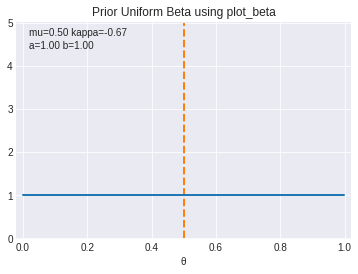

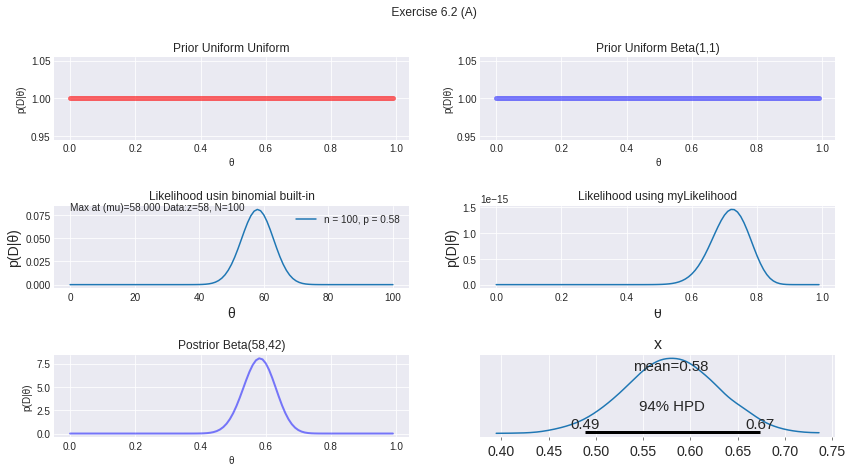

In [8]:
# A) Suppose that before the newspaper poll, your prior belief was a uniform distribution. 
# What is the 95% HDI on your beliefs after learning of the newspaper poll results?

# #TODO 
# domain = np.arange(0.00,1.00,0.001)     #1000 
# with pm.Model():

#         
#         beta = pm.Beta(
#             name=f"theta62", 
#             alpha=1,
#             beta=1,
#             transform=None
#         )
#  im62 = posterior values
# im62 = [ math.exp( beta.logp( {"theta62": t} ) ) # scipy also implements density functions, might be easier and faster to use directly
#                          for t in domain
#                     ]

# plt.bar(domain, im62)

# plt.axis([-0.05, 2.05, -0.05, 1.5])
# plt.axis([-0.05, 2.05, -0.05, 1.5])

a, b = 1, 1

##### Prior Uniform Beta(1,1) using plot_beta
def mu_from_ab(a, b): return a / (a+b)
def Variance_from_ab(a, b): return a * b / (a+b) ** 2  * (a+b+1)
def kappa_from_muVar(mu, variance): return (mu * (1-mu) / variance ) - 1
# ω = (a − 1)/(a + b − 2) for a > 1 and b > 1
def mode_from_ab(a,b): 
    if a == b:
        return mu_from_ab(a,b)
    else:
        return (a - 1)/(a + b - 2)

   
fig, ax1 = plt.subplots(1, 1)
# a, b = 1, 1
m = mu_from_ab(a,b) 
v = Variance_from_ab(a,b)
k = kappa_from_muVar(m, v)
l = "mu"
plot_beta (ax = ax1, a=a, b=b, mu=m, kappa=k, label=l)
ax1.set_title('Prior Uniform Beta using plot_beta');
######

import scipy.stats as st

fig, ax = plt.subplots(3, 2, figsize=(14,7))
fig.suptitle(' Exercise 6.2 (A)')
fig.subplots_adjust(hspace = 0.8) # add some vertical whitespace so that plots do not overlap

### Uniform Uniform Prior
uniform = st.uniform()
θ = np.arange(0.00, 1.0, 0.01)      
ax[0][0].set_title('Prior Uniform Uniform') 
ax[0][0].plot(θ, uniform.pdf(θ), 'r-', lw=5, alpha=0.6, label='uniform pdf')
ax[0][0].set_xlabel('θ')
ax[0][0].set_ylabel('p(D|θ)')

# print(f"Prior Uniform Uniform mean= {mean}")

### Uniform Beta Prior
mean, var, skew, kurt = st.beta.stats(a, b, moments='mvsk')
# x = np.linspace(st.beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
x = np.arange(0.00, 1.0, 0.01)  # 100    
ax[0,1].set_title('Prior Uniform Beta(1,1)') 
ax[0,1].plot(x, st.beta.pdf(x, a, b),'b-', lw=5, alpha=0.5, label='beta pdf')
ax[0][1].set_xlabel('θ')
ax[0,1].set_ylabel('p(D|θ)')

print(f"Prior Uniform Beta mean= {mean}")


# ΤΟDO Is it posterior?
###                        Likelihood usin binomial built-in
plt.style.use('seaborn-darkgrid')
x = np.arange(0, 101)
z = 58
p = z/100
ns = [100]
ps = [p]

ax[1][0].set_title('Likelihood usin binomial built-in')
for n, p in zip(ns, ps):
    pmf = st.binom.pmf(x, n, p)
#     ax[0][1].bar(x, pmf, width=0.01, label='n = {}, p = {}'.format(n, p))
    ax[1][0].plot(x, pmf, '-', label='n = {}, p = {}'.format(n, p)) 
    
ax[1,0].set_xlabel('θ', fontsize=14)
ax[1][0].set_ylabel('p(D|θ)', fontsize=14)
ax[1,0].text(0.01, 0.08, f"Max at (mu)={(ns[0] * p):0.3f} Data:z={z}, N={100}")
ax[1][0].legend(loc=1)



### Likelihood binomial myLikelihood
ax[1][1].set_title('Likelihood using myLikelihood')
ax[1,1].plot(θ, Likelihood(θ, 58, 42)) 
ax[1,1].set_xlabel('θ', fontsize=14)
ax[1][1].set_ylabel('p(D|θ)', fontsize=14)
# ax[1,1].text(0.01, 0.08, f"Max at (mu)={(ns[0] * p):0.3f} Data:z={z}, N={100}")
# ax[1][1].legend(loc=1)


### Postrior Beta
mean1, var1, skew1, kurt1 = st.beta.stats(58, 42, moments='mvsk')
# x = np.linspace(st.beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
θ = np.arange(0.00, 1.0, 0.01)  #100    

ax[2,0].set_title('Postrior Beta(58,42)') 
ax[2,0].plot(θ, st.beta.pdf(θ, 58, 42),'b-', lw=2, alpha=0.5, label='beta pdf')
ax[2][0].set_xlabel('θ')
ax[2,0].set_ylabel('p(D|θ)')
     
    
# ΤODO Why hpd is from 0 ?!  
import arviz as az    
hpd2 = az.hpd(st.beta.pdf(θ, 58, 42), credible_interval=.94)

hpd = pm.stats.hpd(st.beta.pdf(θ, 58, 42), credible_interval=.94)



print(f"Postrior mean= {mean1}")
print(f"The 95% HDI/HPD (pm.stats.hpd) for probability of candidate A is {hpd[0]} to {hpd[1]}")
print(f"The 95% HDI/HPD (az.hpd) for probability of candidate A is {hpd2[0]} to {hpd2[1]}")


print(hpd)

print(f"mean(59,43) = {mu_from_ab(58,42)}")
print(f"mean(1,1) = {mu_from_ab(1,1)}")

print(f"mode (59,43) = {mode_from_ab(58,42)}")
print(f"mode (1,1) ={mode_from_ab(1,1)}")


hpd3 = pm.stats.hpd(np.random.beta(a=58, b=42,size=10000))


az.plot_posterior(np.random.beta(a=58, b=42,size=10000), ax= ax[2,1])

print(hpd3)
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e70050a90>],
      dtype=object)

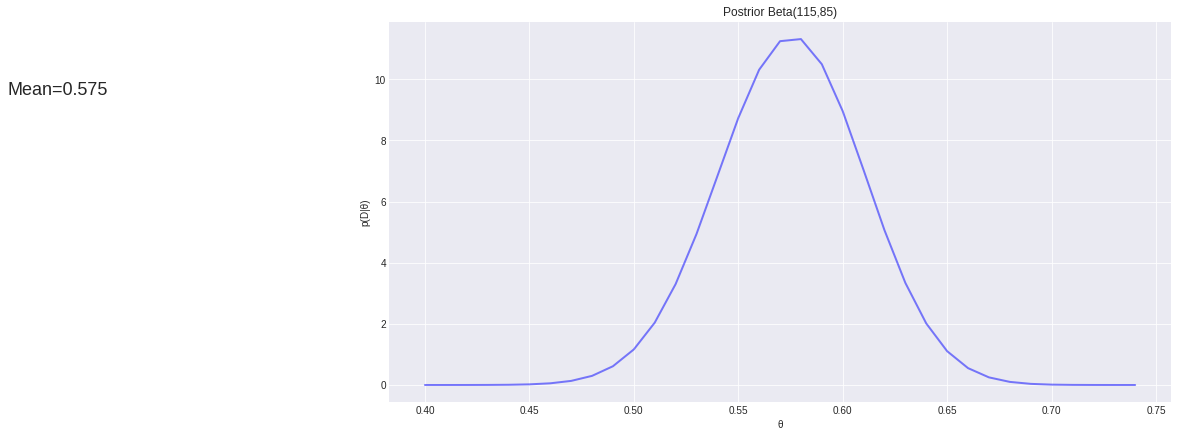

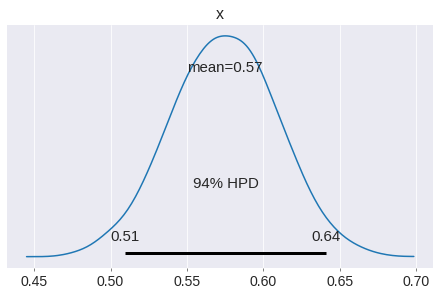

In [9]:
# B) You want to conduct a follow-up poll to narrow down your estimate of the population’s preference. 
# In your follow-up poll, you randomly sample 100 other people and find that 57 prefer candidate A and 
# the remainder prefer candidate B. Assuming that peoples’ opinions have not changed between polls, 
# what is the 95% HDI on the posterior?
θ = np.arange(0.40, 0.75, 0.01)  #200
a = 115
b = 85
# a: a+z= 6, b: b+n-z= 6
# 58 42
fig, ax = plt.subplots(1, 1, figsize=(14,7))

ax.set_title('Postrior Beta(115,85)') 
ax.plot(θ, st.beta.pdf(θ, 115, 85),'b-', lw=2, alpha=0.5, label='beta pdf')
ax.set_xlabel('θ')
ax.set_ylabel('p(D|θ)')

# TODO How to find mode? mode_from_ab
mean2, var2, skew2, kurt2 = st.beta.stats(115, 85, moments='mvsk')
ax.text(0.2,9.5, f"Mean={mean2}", fontsize=18)

az.plot_posterior(np.random.beta(a=115, b=85,size=10000))


**Exercise 6.3**

Exercise 6.3. [Purpose: Apply the Bayesian method to real data analysis. These
data are representative of real data (Kruschke, 2009).] Suppose you train people
in a simple learning experiment, as follows. When people see the two words, “radio” and
“ocean,” on the computer screen, they should press the F key on the computer keyboard.
They see several repetitions and learn the response well. Then you introduce another
correspondence for them to learn: Whenever the words “radio” and “mountain” appear,
they should press the J key on the computer keyboard. You keep training them until they
know both correspondences well. Now you probe what they’ve learned by asking them
about two novel test items. For the first test, you show them the word “radio” by itself
and instruct them to make the best response (F or J) based on what they learned before.
For the second test, you show them the two words “ocean” and “mountain” and ask
them to make the best response. You do this procedure with **50 people**. Your data show
that for “radio” by itself, **40 people chose F and **10 chose J**. For the word combination
“ocean” and “mountain,” **15 chose F and 35 chose J**. Are people biased toward F or
toward J for either of the two probe types? To answer this question, assume a uniform
prior, and use a 95% HDI to decide which biases can be declared to be credible. (Consult
Chapter 12 for how to declare a parameter value to be not credible.)

The 95% HDI/HPD (pm.stats.hpd) for probability of Beta(40,10) is 0.0 to 6.253804701030357
The 95% HDI/HPD (pm.stats.hpd) for probability of Beta(40,10) is 0.0 to 5.626521487857791


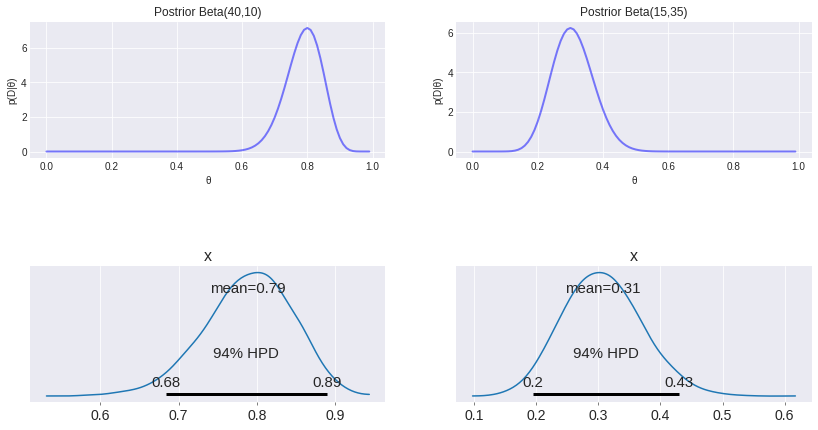

In [10]:
# 6.3
#TODO Is alpha #heads and beta #tail? Yes
#TODO Should I take the prior beta(1,1) to account? a: a+z, b: b+n-z Yes
import scipy.stats as st
import arviz as az

fig, ax = plt.subplots(2, 2, figsize=(14,7))
fig.subplots_adjust(hspace = 0.8) # add some vertical whitespace so that plots do not overlap

# TODO Why it should be 1000? It can be any number but in interval[0,1]
x = np.arange(0.00, 1.00, 0.01)  #
a, b= 1, 1
# a: a+z, b: b+n-z
n=50
z=40
ax[0,0].set_title('Postrior Beta(40,10)') 
ax[0,0].plot(x, st.beta.pdf(x, 41, 11),'b-', lw=2, alpha=0.5, label='beta pdf')
ax[0,0].set_xlabel('θ')
ax[0,0].set_ylabel('p(D|θ)')

n=50
z=15
ax[0,1].set_title('Postrior Beta(15,35)') 
ax[0,1].plot(x, st.beta.pdf(x, 16, 36),'b-', lw=2, alpha=0.5, label='beta pdf')
ax[0,1].set_xlabel('θ')
ax[0,1].set_ylabel('p(D|θ)')

hpd = pm.stats.hpd(st.beta.pdf(x, 41, 11), credible_interval=.94)
print(f"The 95% HDI/HPD (pm.stats.hpd) for probability of Beta(40,10) is {hpd[0]} to {hpd[1]}")


hpd2 = pm.stats.hpd(st.beta.pdf(x, 16, 36), credible_interval=.94)
print(f"The 95% HDI/HPD (pm.stats.hpd) for probability of Beta(40,10) is {hpd2[0]} to {hpd2[1]}")

az.plot_posterior(np.random.beta(a=41, b=11,size=10000), ax=ax[1,0])
# The posterior 95% HDI goes from 0.677 to 0.893, which excludes any reasonable ROPE around
# theta=0.5. In other words, we reject the null value of theta=0.5 because the 95% most
# credible values are all not practically equivalent to theta=0.5.
az.plot_posterior(np.random.beta(a=16, b=36,size=10000), ax=ax[1,1])
# The posterior 95% HDI goes from 0.187 to 0.433, which excludes any reasonable ROPE around
# theta=0.5. In other words, we reject the null value of theta=0.5 because the 95% most
# credible values are all not practically equivalent to theta=0.5.



**Exercise 6.4**

[Purpose: To explore an unusual prior and learn about the beta
distribution in the process.] Suppose we have a coin that we know comes from a
magic-trick store, and therefore we believe that the coin is strongly biased either usually
to come up heads or usually to come up tails, but we don’t know which. Express this
belief as a beta prior. (Hint: See Figure 6.1, upper-left panel.) Now we flip the coin
5 times and it comes up heads in 4 of the 5 flips. What is the posterior distribution?
(Use the R function of Section 6.6 ( BernBeta.R ) to see graphs of the prior and
posterior.)

The 95% HDI/HPD (pm.stats.hpd) for probability of Beta(40,10) is 0.0 to 3.076646660450948


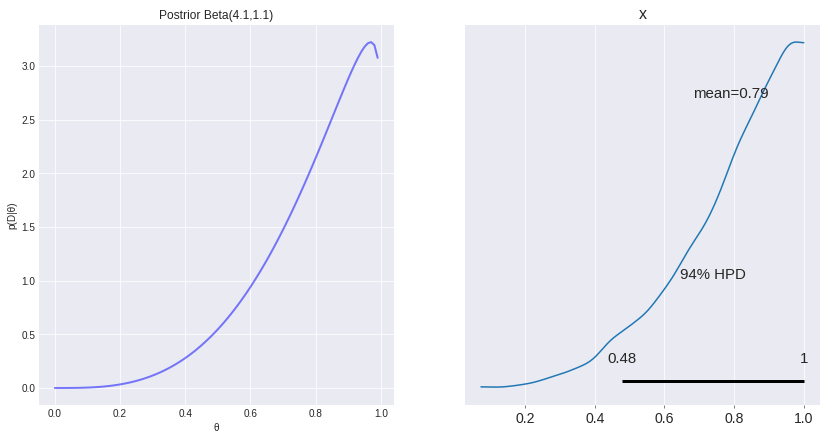

In [11]:
# 6.4
fig, ax = plt.subplots(1, 2, figsize=(14,7))
x = np.arange(0.00, 1.00, 0.01)  
a, b= 0.1, 0.1
# a: a+z, b: b+n-z
n=5
z=4
ax[0].set_title('Postrior Beta(4.1,1.1)') 
ax[0].plot(x, st.beta.pdf(x, 4.1, 1.1),'b-', lw=2, alpha=0.5, label='beta pdf')
ax[0].set_xlabel('θ')
ax[0].set_ylabel('p(D|θ)')


hpd = pm.stats.hpd(st.beta.pdf(x, 4.1, 1.1), credible_interval=.94)
print(f"The 95% HDI/HPD (pm.stats.hpd) for probability of Beta(40,10) is {hpd[0]} to {hpd[1]}")


az.plot_posterior(np.random.beta(a=4.1, b=1.1,size=10000), ax = ax[1])

**Exercise 6.5** 

[Purpose: To get hands on experience with the goal of predicting
the next datum, and to see how the prior influences that prediction.]

(A) Suppose you have a coin that you know is minted by the government and has
not been tampered with. Therefore you have a strong prior belief that the coin is fair.
You flip the coin 10 times and get 9 heads. What is your predicted probability of heads
for the 11th flip? Explain your answer carefully; justify your choice of prior.

(B) Now you have a different coin, this one made of some strange material and
marked (in fine print) “Patent Pending, International Magic, Inc.” You flip the coin 10
times and get 9 heads. What is your predicted probability of heads for the 11th flip?
Explain your answer carefully; justify your choice of prior. Hint: Use the prior from
Exercise 6.4.

Text(0.2, 25, 'mode= 0.5054617676266137')

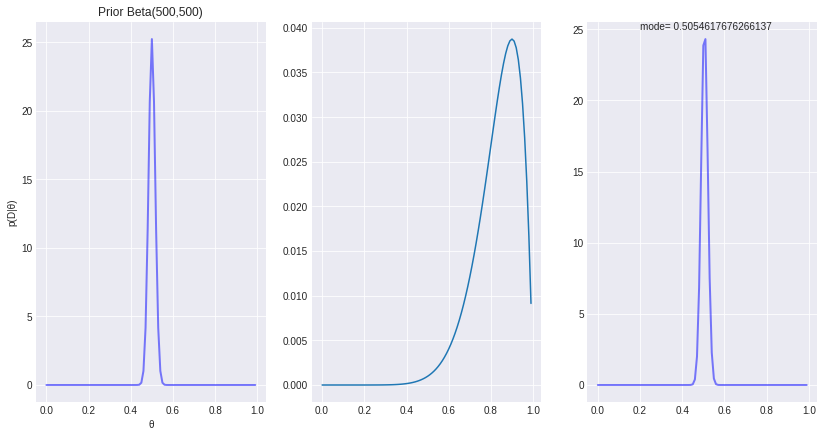

In [12]:
# 6.5 A)
# For the strong prior belief, let’s suppose it’s equivalent to previously seeing 1,000 flips of the
# coin and observing 50% (i.e., 500) heads. So the prior is dbeta(theta|500,500). You could use
# something different, but it should be sharply peaked at theta=0.5.
fig, ax = plt.subplots(1, 3, figsize=(14,7))
x = np.arange(0.00, 1.00, 0.01)  # interval
a, b= 500, 500
# a: a+z, b: b+n-z
n=10
z=9
ax[0].set_title('Prior Beta(500,500)') 
ax[0].plot(x, st.beta.pdf(x, a, b),'b-', lw=2, alpha=0.5, label='beta pdf')
ax[0].set_xlabel('θ')
ax[0].set_ylabel('p(D|θ)')

def Likelihood(θ, n, z): return θ**z * (1-θ)**(n-z) # Bernouli/binomial likelihood
ax[1].plot(x, Likelihood(x, 10, 9))

# a: a+z , b: b+n-z=
ax[2].plot(x, st.beta.pdf(x, a+10, b+9-10),'b-', lw=2, alpha=0.5, label='beta pdf')

def mode_from_ab(a,b): 
    if a == b:
        return mu_from_ab(a,b)
    else:
        return (a - 1)/(a + b - 2)
    
ax[2].text(.2, 25, f'mode= {mode_from_ab(a+10, b+9-10)}')


# The predicted probability of heads on the next flip is the mean of the posterior distribution,
# which in this case is 0.504 (as displayed in the graph). Thus, even though the new data showed
# 90% heads, the strong prior keeps the posterior prediction very nearly 50%.

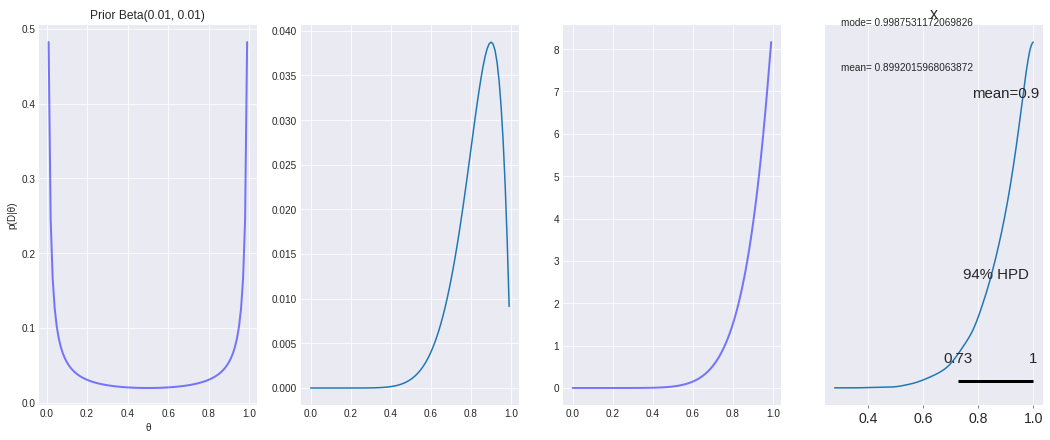

In [13]:
# 6.5 B)
# Now you have a different coin, this one made of some strange material and marked (in fine print) 
# Patent Pending, International Magic, Inc.” You flip the coin 10 times and get 9 heads. What is your 
# predicted probability of heads for the 11th flip? Explain your answer carefully; justify your choice of prior.
# Hint: Use the prior from Exercise 6.4.

# to express a strong prior belief that
# the coin is strongly heads biased or strongly tails biased.


fig, ax = plt.subplots(1, 4, figsize=(18,7))
x = np.arange(0.00, 1.00, 0.01)  # interval
a, b= 0.01, 0.01
# a: a+z, b: b+n-z

ax[0].set_title('Prior Beta(0.01, 0.01)') 
ax[0].plot(x, st.beta.pdf(x, a, b),'b-', lw=2, alpha=0.5, label='beta pdf')
ax[0].set_xlabel('θ')
ax[0].set_ylabel('p(D|θ)')

def Likelihood(θ, n, z): return θ**z * (1-θ)**(n-z) # Bernouli/binomial likelihood
ax[1].plot(x, Likelihood(x, 10, 9))

# a: a+z , b: b+n-z=
ax[2].plot(x, st.beta.pdf(x, 9.01, 1.01),'b-', lw=2, alpha=0.5, label='beta pdf')

def mode_from_ab(a,b): 
    if a == b:
        return mu_from_ab(a,b)
    else:
        return (a - 1)/(a + b - 2)
    
def mu_from_ab(a, b): return a / (a+b)

az.plot_posterior(np.random.beta(a=9.01, b=1.01,size=10000), ax=ax[3])
ax[3].text(.3, 8, f'mode= {mode_from_ab(9.01, 1.01)}')
ax[3].text(.3, 7, f'mean= {mu_from_ab(9.01, 1.01)}');

# The predicted probability of heads on the next flip is the mean of the posterior distribution,
# which is 0.899 (as displayed in the graph).